In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from math import sqrt

%matplotlib inline


In [2]:
# Classify a song as 'rock' or 'jazz'

music = pd.DataFrame()

# Some data to play with.
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]

# We know whether the songs in our training data are jazz or not.
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


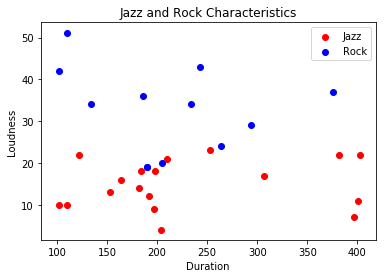

In [3]:
# Looking at our data
plt.scatter(
    music[music['jazz'] == 1].duration,
    music[music['jazz'] == 1].loudness,
    color='red'
)
plt.scatter(
    music[music['jazz'] == 0].duration,
    music[music['jazz'] == 0].loudness,
    color='blue'
)
plt.legend(['Jazz', 'Rock'])
plt.title('Jazz and Rock Characteristics')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
# Prediction with 1 neighbor
neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X, Y)

## Predict for a song with 24 loudness that's 190 seocnds long
neighbors.predict([[10, 190]])

array([1])

In [5]:
# Prediction with 5 neighbors
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X, Y)
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))


[1]
[[0.4 0.6]]


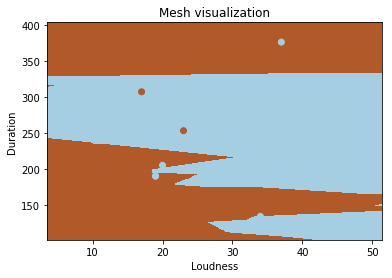

In [9]:
# Create a mesh to generate prediction over whole space
X = np.array(X)
Y = np.array(Y)

# Mesh size
h = .1

# Plot the decision boundary.  W3 assign a color to each point in the mesh
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
# np.c_ is short for np.concatenate on the second axis
# .ravel() returns a flattened array, equivalent to reshape(-1, order=order).
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put hte result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize = (6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Mesh starts to show significant delay at h = .05, still good at h = .1.

## Implement Nearest Neighbor algorithm


In [32]:
def NearestNeighbor(x_data, y_data, x):
    
    min_distance = sqrt((x_data.iloc[0, 0] - x[0])**2 + (x_data.iloc[0, 1] - x[1])**2)
    predict = y_data[0]
    
    for i in range(1, len(x_data)):
        distance = sqrt((x_data.iloc[i, 0] - x[0])**2 + (x_data.iloc[i, 1] - x[1])**2)
        if distance < min_distance:
            min_distance = distance
            predict = y_data[i]
    return predict

In [38]:
predict = NearestNeighbor(music[['loudness', 'duration']], music['jazz'], [10, 190])
print(predict)

1


In [77]:
# Implement my own version of kNearestNeighbor for understanding, this is a brute force method

def KNearestNeighbor(x_data, y_data, x, k=1):
    predict = []
    for i in range(k):
        min_distance = sqrt((x_data.iloc[i, 0] - x[0])**2 + (x_data.iloc[i, 1] - x[1])**2)
        predict.append([min_distance, y_data[i]])
    predict.sort()
    
    for i in range(k, len(x_data)):
        distance = sqrt((x_data.iloc[i, 0] - x[0])**2 + (x_data.iloc[i, 1] - x[1])**2)
        if distance < predict[-1][0]:
            predict[-1] = [distance, y_data[i]]
            predict.sort()
    
    # This is the percent of 1's
    percent = sum(p[1] for p in predict) / k
    
    # This version predicts 1 for a tie, could implement tiebreaker as closer distance
    if percent >= 0.5:
        overall_predict = 1
    else:
        overall_predict = 0
    
    return overall_predict, [1-percent, percent]

In [84]:
predict, perc = KNearestNeighbor(music[['loudness', 'duration']], music['jazz'], [24, 190], k=3)

In [85]:
predict

0

In [86]:
perc

[0.6666666666666667, 0.3333333333333333]

## 3.2.1 Adding Weights to the Model 

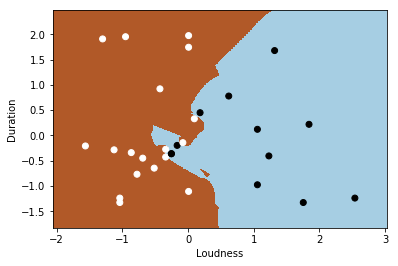

In [96]:
from scipy import stats

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Our input data frame will be the z-scores, this time instead of raw data
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit our model
Y = music.jazz
neighbors.fit(X, Y)

# Arrays, not data frames for the mesh
X = np.array(X)
Y = np.array(Y)

# Mesh size
h = .01

# Plot the decision boundary
# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='gray')
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()


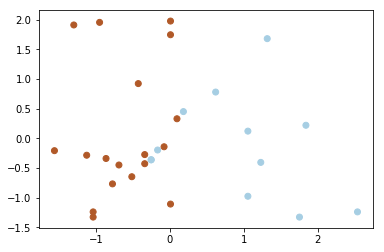

In [97]:
plt.scatter(X[:,0], X[:,1], c=Y)